## <center><b>Lab 10 - Fine-Tune VGG16 for Bird Classification</b></center>
<center>Done by: Aardran Premakumar <br> 8844491</center>

### <center> <b> Importing all needed libraries </b> </center>

In [115]:

import os, shutil, pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_curve,auc
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, recall_score
import numpy as np

### <center> <b> Setting the path of train, validation, and test data </b> </center>

In [3]:
og_dir = pathlib.Path(r"C:\Users\aardr\Desktop\aaiml_works\mlfoundation\CSCN8010\data\birds")

In [4]:
train_dir = pathlib.Path(r"C:\Users\aardr\Desktop\aaiml_works\mlfoundation\CSCN8010\data\birds\train")
val_dir = pathlib.Path(r"C:\Users\aardr\Desktop\aaiml_works\mlfoundation\CSCN8010\data\birds\valid")
test_dir = pathlib.Path(r"C:\Users\aardr\Desktop\aaiml_works\mlfoundation\CSCN8010\data\birds\test")

### <center> <b> Finding the top three classes from the directory </b></center>

In [5]:
# list comprehension to get all the class folders in the training directory
class_folders = [folder for folder in train_dir.iterdir() if folder.is_dir()]  #iterdir() used to iterate through the directory

class_image_count = {} # dictionary to store the class name and the number of images in that class
for folder in class_folders: # iterate through each class folder
    num_images = len(list(folder.glob('*')))
    class_image_count[folder.name] = num_images

#sorting the dictionary as descending order by the no. of images in each class
sorted_classes = sorted(class_image_count.items(), key=lambda x: x[1], reverse=True) 
top_three_classes = sorted_classes[:3] # get the top three classes

print("Top three classes with the highest number of images:")
for class_name, count in top_three_classes:
    print(f"{class_name}: {count} images")

# list created to store the top three classes
class_list = [c[0] for c in top_three_classes]

Top three classes with the highest number of images:
RUFOUS TREPE: 263 images
HOUSE FINCH: 248 images
D-ARNAUDS BARBET: 233 images


In [6]:
# function to delete the unused classes
def delete_unused_species(directory, class_list):
    dir_path = directory
    for species in dir_path.iterdir():
        if species.name not in class_list:
            delete_path = dir_path / species
            if delete_path.is_dir():
                shutil.rmtree(delete_path)

delete_unused_species(train_dir, class_list)
delete_unused_species(test_dir, class_list)
delete_unused_species(val_dir, class_list)

### <center> <b> Data Augmentation and Generators </b></center>

In [7]:
# Define the image data generator with specified augmentations
data_agu_pre = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    horizontal_flip=True,
    fill_mode='nearest'
)

# Common parameters for generators
common_params = {
    "target_size": (224, 224),
    "batch_size": 32,
    "class_mode": 'categorical'
}

# Create generators for training, validation, and testing
train_generator = data_agu_pre.flow_from_directory(
    train_dir,
    **common_params
)

val_generator = data_agu_pre.flow_from_directory(
    val_dir,
    **common_params
)

test_generator = data_agu_pre.flow_from_directory(
    test_dir,
    shuffle=False,
    **common_params
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


### <center> <b> Loading Pre-trained VGG model </b></center>

In [9]:
# Create the base model from the pre-trained model VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### <center> <b> Custom layers for data and freezing some layers</b></center>

In [10]:
# Get the output tensor of the base model
conv_output = conv_base.output

# Apply Global Average Pooling 2D
x = GlobalAveragePooling2D()(conv_output)

# Add a Dense layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add the final Dense layer with 3 units (assuming 3 classes) and softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the new model using the Functional API
model = Model(inputs=conv_base.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# freeze the layers of the base model
for layer in conv_base.layers:
    layer.trainable = False

### <center> <b> Compiling and training model </b></center>

In [12]:
# Compile the model
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# Train the model
history = model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10


24/24 [==============================] - 56s 2s/step - loss: 0.7932 - accuracy: 0.6868 - val_loss: 0.3742 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 54s 2s/step - loss: 0.3607 - accuracy: 0.8992 - val_loss: 0.1263 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 53s 2s/step - loss: 0.2611 - accuracy: 0.9220 - val_loss: 0.0695 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 52s 2s/step - loss: 0.2238 - accuracy: 0.9261 - val_loss: 0.0772 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 53s 2s/step - loss: 0.1829 - accuracy: 0.9422 - val_loss: 0.0793 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 53s 2s/step - loss: 0.1540 - accuracy: 0.9543 - val_loss: 0.0461 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 54s 2s/step - loss: 0.1427 - accuracy: 0.9530 - val_loss: 0.0345 - val_accuracy: 1.0000
Epoch 8/10
24/24 [=============

### <center> <b> Model Evaluation </b></center>

In [70]:
y_pred = model.predict(val_generator) # predict the classes using the validation generator
y_pred_tre = val_generator.classes # get the true classes of the validation generator
y_pred_class = np.argmax(y_pred, axis=1)

1/1 [==============================] - 2s 2s/step


### <center> <b> Performance Metrics </b></center>

In [107]:
confusion_mat = confusion_matrix(y_pred_tre, y_pred_class) #confusion matrix
report = classification_report(y_pred_tre, y_pred_class,target_names=val_generator.class_indices.keys()) #classification report
test_loss, test_acc = model.evaluate(test_generator) #test loss and accuracy
f1_scr = f1_score(y_pred_tre, y_pred_class, average='weighted') #f1 score
recall_scr = recall_score(y_pred_tre, y_pred_class, average= 'weighted') #recall score

1/1 [==============================] - 2s 2s/step - loss: 0.0171 - accuracy: 1.0000


In [113]:
print("\nTest Accuracy: ", test_acc)
print("\nF1 Score: ", f1_scr)
print("\nRecall Score: " ,recall_scr)
print("\nConfusion Matrix: \n", confusion_mat)
print("\nClassification Report: \n", report)


Test Accuracy:  1.0

F1 Score:  0.13333333333333336

Recall Score:  0.13333333333333333

Confusion Matrix: 
 [[0 4 1]
 [1 1 3]
 [4 0 1]]

Classification Report: 
                   precision    recall  f1-score   support

D-ARNAUDS BARBET       0.00      0.00      0.00         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.20      0.20      0.20         5

        accuracy                           0.13        15
       macro avg       0.13      0.13      0.13        15
    weighted avg       0.13      0.13      0.13        15



In [114]:
val_loss, val_acc = model.evaluate(val_generator) #validation loss and accuracy

print("\nValidation Accuracy: ", val_acc)

1/1 [==============================] - 2s 2s/step - loss: 0.0708 - accuracy: 1.0000

Validation Accuracy:  1.0


In [100]:
acc = history.history['accuracy'] # accuracy for training set
val_accc = history.history['val_accuracy'] # accuracy for validation set
loss = history.history['loss'] # loss for training set
val_losss = history.history['val_loss'] # loss for validation set
epochs = range(1, len(acc) + 1) # number of epochs

In [92]:
# printing to checking the values of validation accuracy and loss
print(val_accc)
print(val_losss)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.3742367923259735, 0.12629066407680511, 0.06953517347574234, 0.07718633860349655, 0.07929670810699463, 0.04611383378505707, 0.03452784940600395, 0.022617517039179802, 0.029087381437420845, 0.06302767246961594]


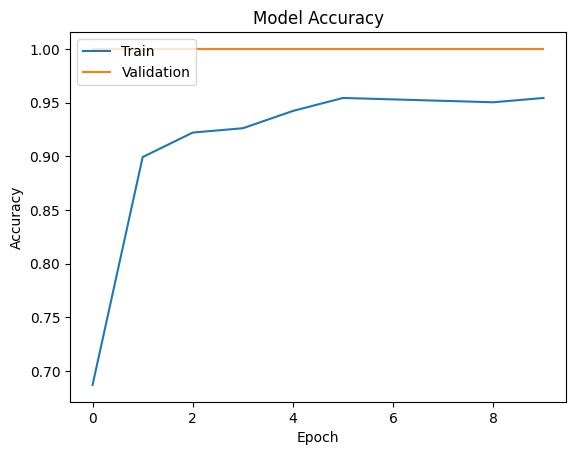

In [75]:
# Plot training & validation accuracy values
plt.plot(acc)
plt.plot(val_accc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

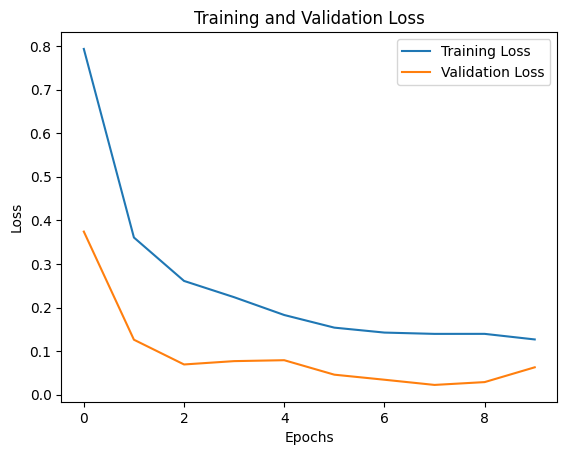

In [76]:
# Plot training and validation loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_losss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

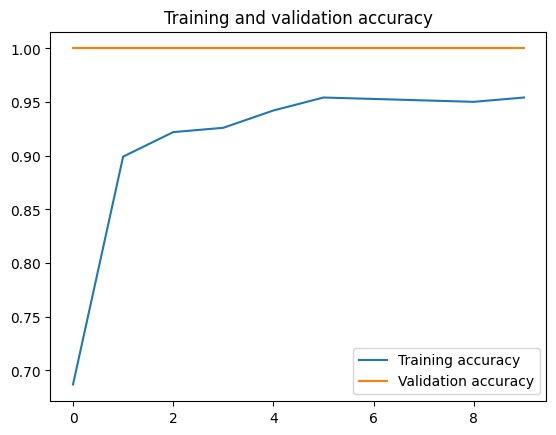

<Figure size 640x480 with 0 Axes>

In [77]:
# Plot training and validation accuracy values
plt.plot(acc, label="Training accuracy")
plt.plot(val_accc, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

### <center> <b> Precision - Recall Curve </b></center>

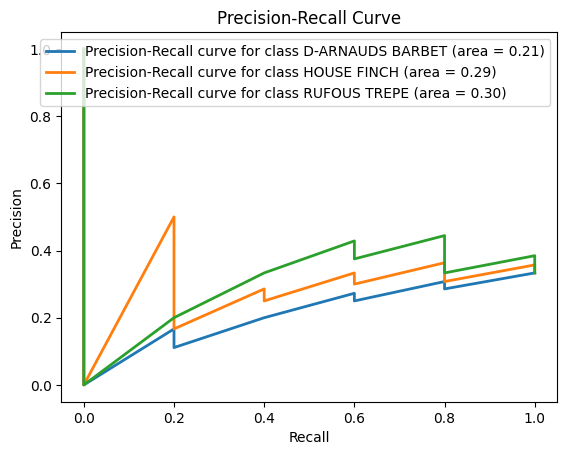

In [79]:
class_label = list(test_generator.class_indices.keys()) # list of class labels
true_classes = test_generator.classes # true classes of the test generator

# Convert the true_classes to binary labels for each class
binary_labels = np.zeros_like(y_pred)
for i in range(len(class_label)):
    binary_labels[:, i] = (true_classes == i)

# Calculate precision and recall for each class
precision = dict()
recall = dict()
pre_auc = dict()
for i in range(len(class_label)):
    precision[i], recall[i], _ = precision_recall_curve(binary_labels[:, i], y_pred[:, i])
    pre_auc[i] = auc(recall[i], precision[i])
    
# Plot the precision-recall curves for each class
plt.figure()
for i in range(len(class_label)):
    plt.plot(recall[i], precision[i], lw=2, label='Precision-Recall curve for class {} (area = {:0.2f})'.format(class_label[i], pre_auc[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### <center> <b>AUC Score</b></center>

In [83]:
from sklearn.metrics import roc_auc_score
# class_labels = ["D-ARNAUDS BARBET", "HOUSE FINCH", "RUFOUS TREPE"]  # List of class labels

# Convert the true_classes to binary labels for each class
binary_labels = np.zeros_like(y_pred)
for i in range(len(class_label)):
    binary_labels[:, i] = (true_classes == i)

# Calculate AUC for each class
auc_scores = []
for i in range(len(class_label)):
    auc_score = roc_auc_score(binary_labels[:, i], y_pred[:, i])
    auc_scores.append(auc_score)
    print("AUC for {}: {:.2f}".format(class_label[i], auc_score))

AUC for D-ARNAUDS BARBET: 0.20
AUC for HOUSE FINCH: 0.44
AUC for RUFOUS TREPE: 0.50


### <center><b> Observations based on AUC value </b></center>

1. D-ARNAUDS BARBET (AUC: 0.20):

    - With an AUC of 0.20, it seems the model struggles to tell apart positive and negative instances for D-ARNAUDS BARBET.
    - The curve on the ROC chart hugs the diagonal line, suggesting a weak true positive rate and false positive rate.
    - In simple terms, the model doesn't perform well in recognizing D-ARNAUDS BARBET, and its effectiveness is not up to the mark.<br><br>

2. HOUSE FINCH (AUC: 0.44):

    - The AUC value of 0.44 suggests a so-so performance in distinguishing positive and negative instances for HOUSE FINCH.
    - Looking at the ROC curve, it's a bit away from the diagonal line, indicating a moderate ability to identify true and false positives.
    - While it's not a stellar performance, the model does a bit better in distinguishing HOUSE FINCH compared to D-ARNAUDS BARBET.
<br><br>
3. RUFOUS TREPE (AUC: 0.50):

    - An AUC of 0.50 for RUFOUS TREPE indicates the model's performance is close to random chance in telling positive from negative instances.
    - The ROC curve mimics a random classifier, suggesting an equal chance of getting true and false positives.
    - Essentially, the model's knack for distinguishing RUFOUS TREPE is not much better than if it were guessing, and there's room for improvement in its classification abilities.

### <center> <b>Mis-classified Index</b></center>

Predicted: HOUSE FINCH 
Actual: D-ARNAUDS BARBET


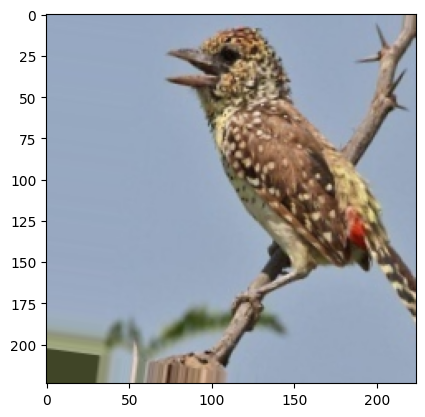

Predicted: HOUSE FINCH 
Actual: D-ARNAUDS BARBET


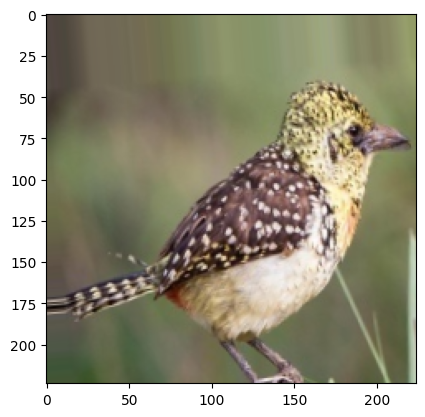

Predicted: RUFOUS TREPE 
Actual: D-ARNAUDS BARBET


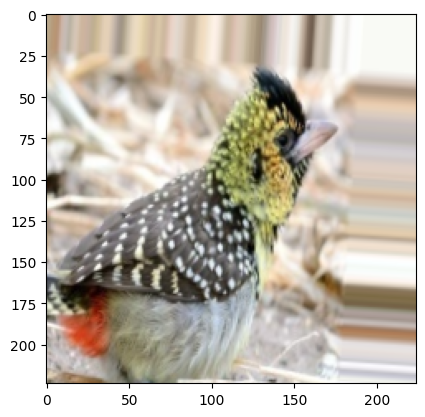

In [96]:
misclassified_indexes = np.where(y_pred_class != true_classes)[0] # get the indexes of the misclassified examples

for index in misclassified_indexes[:3]:  # Display first 3 misclassified examples
    print("Predicted:", class_label[y_pred_class[index]], "\nActual:", class_label[true_classes[index]])
    plt.imshow(test_generator[0][0][index])
    plt.show()
